<a href="https://colab.research.google.com/github/tcotte/CNN_Pytorch/blob/master/Filters_Visualisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Visualization of CNN Layers and Filters

In [ ]:
!git clone https://github.com/tcotte/CNN_Pytorch.git

Cloning into 'CNN_Pytorch'...
remote: Enumerating objects: 21, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 3151 (delta 6), reused 12 (delta 4), pack-reused 3130
Receiving objects: 100% (3151/3151), 223.85 MiB | 35.21 MiB/s, done.
Resolving deltas: 100% (42/42), done.
Checking out files: 100% (3326/3326), done.


In [2]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data.dataloader as dataloader
import torch.optim as optim

from torch.utils.data import TensorDataset

from torchvision import transforms
from torchvision.datasets import MNIST
import torchvision
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms

SEED = 1

# CUDA?
cuda = torch.cuda.is_available()

# For reproducibility
torch.manual_seed(SEED)
device = torch.device("cuda" if cuda else "cpu")

if cuda:
    torch.cuda.manual_seed(SEED)

In [ ]:
import warnings
warnings.filterwarnings("ignore")

## Outline
1. Using torchvision.datasets with a custom folder of images
2. Filter visualisation with pretrained model

## Load dataset

In [ ]:
#reading the labels of data we uploaded
with open("/content/CNN_Pytorch/data/imagenet_labels.txt") as f:classes = eval(f.read())

In [ ]:
#classes = {0: 'Cat', 1: 'Dog'}

In [ ]:
#define the data we uploaded as evaluation data and apply the transformations
imagefolder = "/content/CNN_Pytorch/data/CatVSDog/test"
evalset = torchvision.datasets.ImageFolder(root = imagefolder, transform = transform)

In [ ]:
#create a data loader for evaluation

batch_size=1 #batch size
evalloader = torch.utils.data.DataLoader(evalset, batch_size = batch_size, shuffle = True)

## Load pretrained model

In [ ]:
from CNN_Pytorch.models.custom_arch import Net
model = Net()
 
model = torch.load("/content/CNN_Pytorch/catvsdog_net.pth")
model.eval()

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=44944, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)

In [ ]:
#model.named_parameters()

## Filter visualisation

In [5]:
#for filter visualization, we will use resnet pretrained with imagenet data

resnet = models.resnet50(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [4]:
#for filter visualization, we will use alexnet pretrained with imagenet data

alexnet = models.alexnet(pretrained=True)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth


In [6]:
#structure of the alexnet
print(alexnet)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [7]:
def plot_filters_single_channel_big(t):
    
    #setting the rows and columns
    nrows = t.shape[0]*t.shape[2]
    ncols = t.shape[1]*t.shape[3]
    
    
    npimg = np.array(t.numpy(), np.float32)
    npimg = npimg.transpose((0, 2, 1, 3))
    npimg = npimg.ravel().reshape(nrows, ncols)
    
    npimg = npimg.T
    
    fig, ax = plt.subplots(figsize=(ncols/10, nrows/200))    
    imgplot = sns.heatmap(npimg, xticklabels=False, yticklabels=False, cmap='gray', ax=ax, cbar=False)

In [8]:
def plot_filters_single_channel(t):
    
    #kernels depth * number of kernels
    nplots = t.shape[0]*t.shape[1]
    ncols = 12
    
    nrows = 1 + nplots//ncols
    #convert tensor to numpy image
    npimg = np.array(t.numpy(), np.float32)
    
    count = 0
    fig = plt.figure(figsize=(ncols, nrows))
    
    #looping through all the kernels in each channel
    for i in range(t.shape[0]):
        for j in range(t.shape[1]):
            count += 1
            ax1 = fig.add_subplot(nrows, ncols, count)
            npimg = np.array(t[i, j].numpy(), np.float32)
            npimg = (npimg - np.mean(npimg)) / np.std(npimg)
            npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
            ax1.imshow(npimg)
            ax1.set_title(str(i) + ',' + str(j))
            ax1.axis('off')
            ax1.set_xticklabels([])
            ax1.set_yticklabels([])
   
    plt.tight_layout()
    plt.show()

In [9]:
def plot_filters_multi_channel(t):
    
    #get the number of kernals
    num_kernels = t.shape[0]    
    
    #define number of columns for subplots
    num_cols = 12
    #rows = num of kernels
    num_rows = num_kernels
    
    #set the figure size
    fig = plt.figure(figsize=(num_cols,num_rows))
    
    #looping through all the kernels
    for i in range(t.shape[0]):
        ax1 = fig.add_subplot(num_rows,num_cols,i+1)
        
        #for each kernel, we convert the tensor to numpy 
        npimg = np.array(t[i].numpy(), np.float32)
        #standardize the numpy image
        npimg = (npimg - np.mean(npimg)) / np.std(npimg)
        npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
        npimg = npimg.transpose((1, 2, 0))
        ax1.imshow(npimg)
        ax1.axis('off')
        ax1.set_title(str(i))
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        
    plt.savefig('myimage.png', dpi=100)    
    plt.tight_layout()
    plt.show()

In [10]:
def plot_weights(model, layer_num, single_channel = True, collated = False):
  
  #extracting the model features at the particular layer number
  layer = model.features[layer_num]
  
  #checking whether the layer is convolution layer or not 
  if isinstance(layer, nn.Conv2d):
    #getting the weight tensor data
    weight_tensor = model.features[layer_num].weight.data
    
    if single_channel:
      if collated:
        plot_filters_single_channel_big(weight_tensor)
      else:
        plot_filters_single_channel(weight_tensor)
        
    else:
      if weight_tensor.shape[1] == 3:
        plot_filters_multi_channel(weight_tensor)
      else:
        print("Can only plot weights with three channels with single channel = False")
        
  else:
    print("Can only visualize layers which are convolutional")

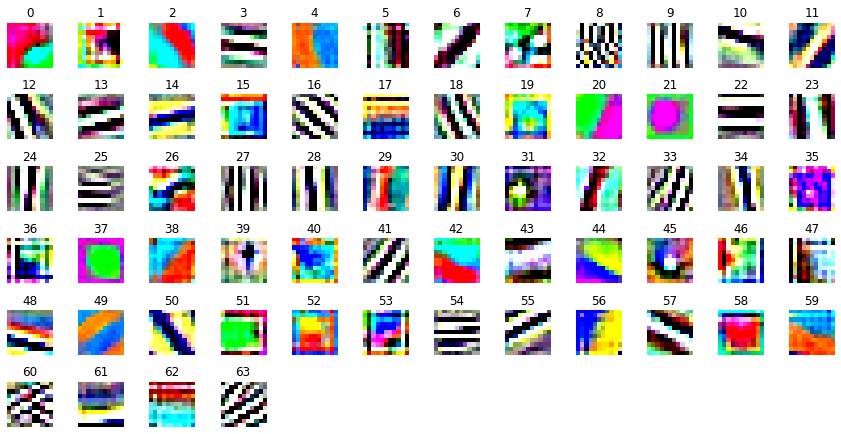

In [12]:
#visualize weights for alexnet - first conv layer

plot_weights(alexnet, 0, single_channel = False)

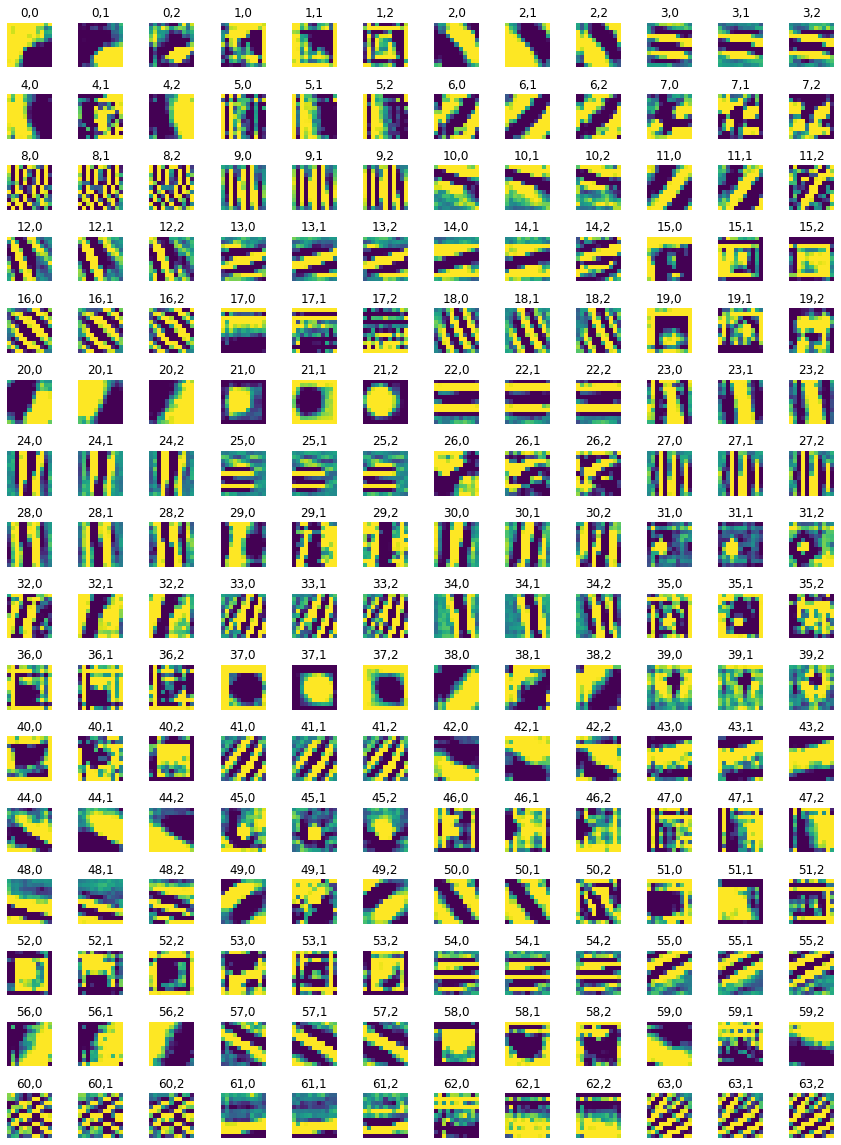

In [ ]:
#plotting single channel images

plot_weights(alexnet, 0, single_channel = True)

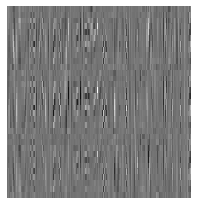

In [ ]:
 plot_weights(alexnet, 0, single_channel = True, collated = True)

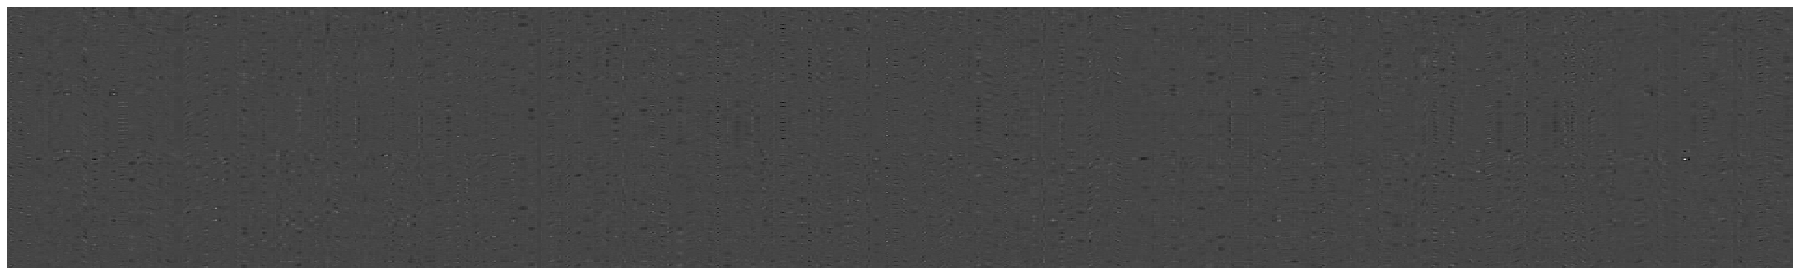

In [ ]:
plot_weights(alexnet, 3, single_channel = True, collated = True)

In [ ]:
#plot for 3rd layer -> 2nd conv layer
#plot_weights(alexnet, 3, single_channel = True)

In [ ]:
#plot_weights(alexnet, 6, single_channel = True, collated = True)

In [ ]:
#for vgg16

#plot_weights(model, 0, single_channel = True, collated = True)

In [ ]:
#plot_weights(model, 2, single_channel = True, collated = True)

In [ ]:
#plot_weights(model, 5, single_channel = True, collated = True)

In [ ]:
#plot_weights(model, 0, single_channel = False, collated = False)